## Bias-Variance Trade-off and Decomposition

One of the critical concepts in data science is the **bias-variance** trade-off. This expresses how certain hyper-parameters affect the error of a model, and how the best model is achieved by finding the minimum error.

The error is often decomposed into **bias** and **variance**. These are theoretical concepts. To calculate bias and variance we need to understand the population, so we can't measure the bias or variance from a sample.

This notebook is an exploration of bias and variance of various models, on a simple fake dataset with one feature.

$\DeclareMathOperator{\E}{\mathbb{E}}$
$\DeclareMathOperator{\Bias}{Bias}$
$\DeclareMathOperator{\Var}{Var}$

Suppose there is some underlying true function $f(x)$, such that $y = f(x) + \epsilon$, where the noise $\epsilon$ has a mean of zero and standard deviation of $\sigma$. We've created some function $\hat f(x)$ to estimate $y$, and want the residuals $|y - \hat f(x)|$ to be as small as possible. We can decompose this into three parts: the  square of the **bias**, the **variance**, and the **irreducible error**.

These are independent, so the some of these (as squares) is equal to the square of the total error.

$$\E\left[(y - \hat f(x))^2\right] = \left(\Bias[\hat f(x)]\right)^2 + \Var[\hat f(x)] + \sigma^2$$

where
$$\Bias[\hat f(x)] = \E[\hat f(x)] - f(x)$$
and
$$\text{Var}[\hat f(x)] = \E[\hat f(x)^2] - \E[\hat f(x)]^2$$


TBD: add derivation.

$$
\begin{align}
\E\left[(y - \hat f(x))^2\right] & = \E\left[(f(x) + \epsilon -
     \hat f(x) +
     \E[\hat f(x)] - \E[\hat f(x)
     )^2\right] \\
     & = 
\end{align}$$

Let's show an example, following the notation above. Let's assume $\sigma$ is 1, the irreducible error is normally distributed, and $f(x)$ is a cosine.

In [89]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import Pipeline

In [90]:
sigma = 1

def f(x):
    return np.cos(x)

def epsilon(x):
    return stats.norm(0, sigma).rvs(len(x))

def y(x):
    return f(x) + epsilon(x)

Now we'll look at it in some range, say, 0 to 10.

In [91]:
xlim = (0, 10)
n_pts = 100
xpts = np.linspace(*xlim, n_pts)
ypts = f(xpts)

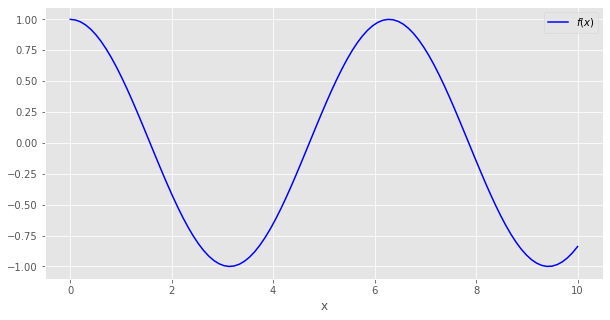

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xpts, ypts, 'b-', label='$f(x)$')
ax.legend()
ax.set_xlabel('x');

Now we'll choose a training sample and fit a model to those data. We'll start with a kNN regressor, first with `k=3`.

In [93]:
sample_size = 50
x_sample = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs(sample_size)
y_sample = y(x_sample)
model = KNeighborsRegressor(3)
model.fit(x_sample[:, None], y_sample)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

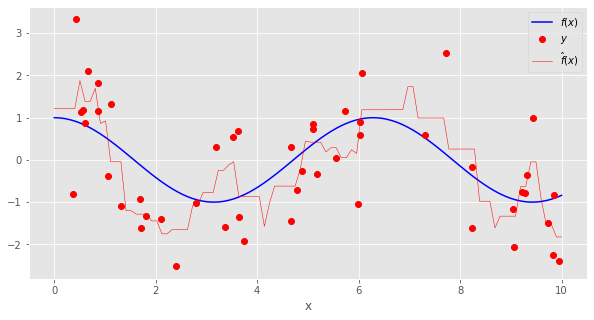

In [94]:
points = ax.plot(x_sample, y_sample, 'ro', label='$y$')
ax.plot(xpts, model.predict(xpts[:, None]), 'r-', lw=0.5, label='$\hat{f}(x)$')
ax.legend()
fig

In [95]:
def plot_bias_variance(ax1, ax2, model, x_samples, label):
    n_trials = x_samples.shape[1]
    predictions = np.zeros((n_trials, n_pts))
    for t in range(n_trials):
        x_sample = x_samples[:, t]
        y_sample = y(x_sample)
        model.fit(x_sample[:, None], y_sample)
        predictions[t, :] = model.predict(xpts[:, None])
        if t%50==0:
            ax1.plot(xpts,
                     predictions[t,:],
                     'r-',
                     lw=0.4,
                     label='$\hat{f}(x)$' if t== 0 else '')
    ax1.plot(xpts, ypts, 'b-', label='$f(x)$')
    ax1.plot(xpts, predictions.mean(axis=0), color='#AA0000', lw=3, label="$\mathbb{E}[\hat f(x)]$")

    ax1.set_ylim((-2, 2))
    ax1.set_title(label)
    ax1.legend()
    #ax[1].plot(xpts, predictions.mean(axis=0) - ypts, 'k', label='bias')
    bias = predictions.mean(axis=0) - ypts
    variance = predictions.var(axis=0)
    ax2.plot(xpts, bias**2, 'k', label='bias$\,^2$')
    ax2.plot(xpts, variance, 'r', label='variance')
    ax2.plot(xpts, bias**2 + variance, 'g', label='total')
    ax2.plot(xpts, np.zeros_like(xpts), 'k', lw=0.5)
    ax2.axhline(np.mean(bias**2 + variance), color='g', ls=':', label='average total')

    ax2.legend()

In [96]:
n_samples = 1000
x_samples = stats.uniform(xlim[0], xlim[1]-xlim[0]).rvs((sample_size, n_samples))

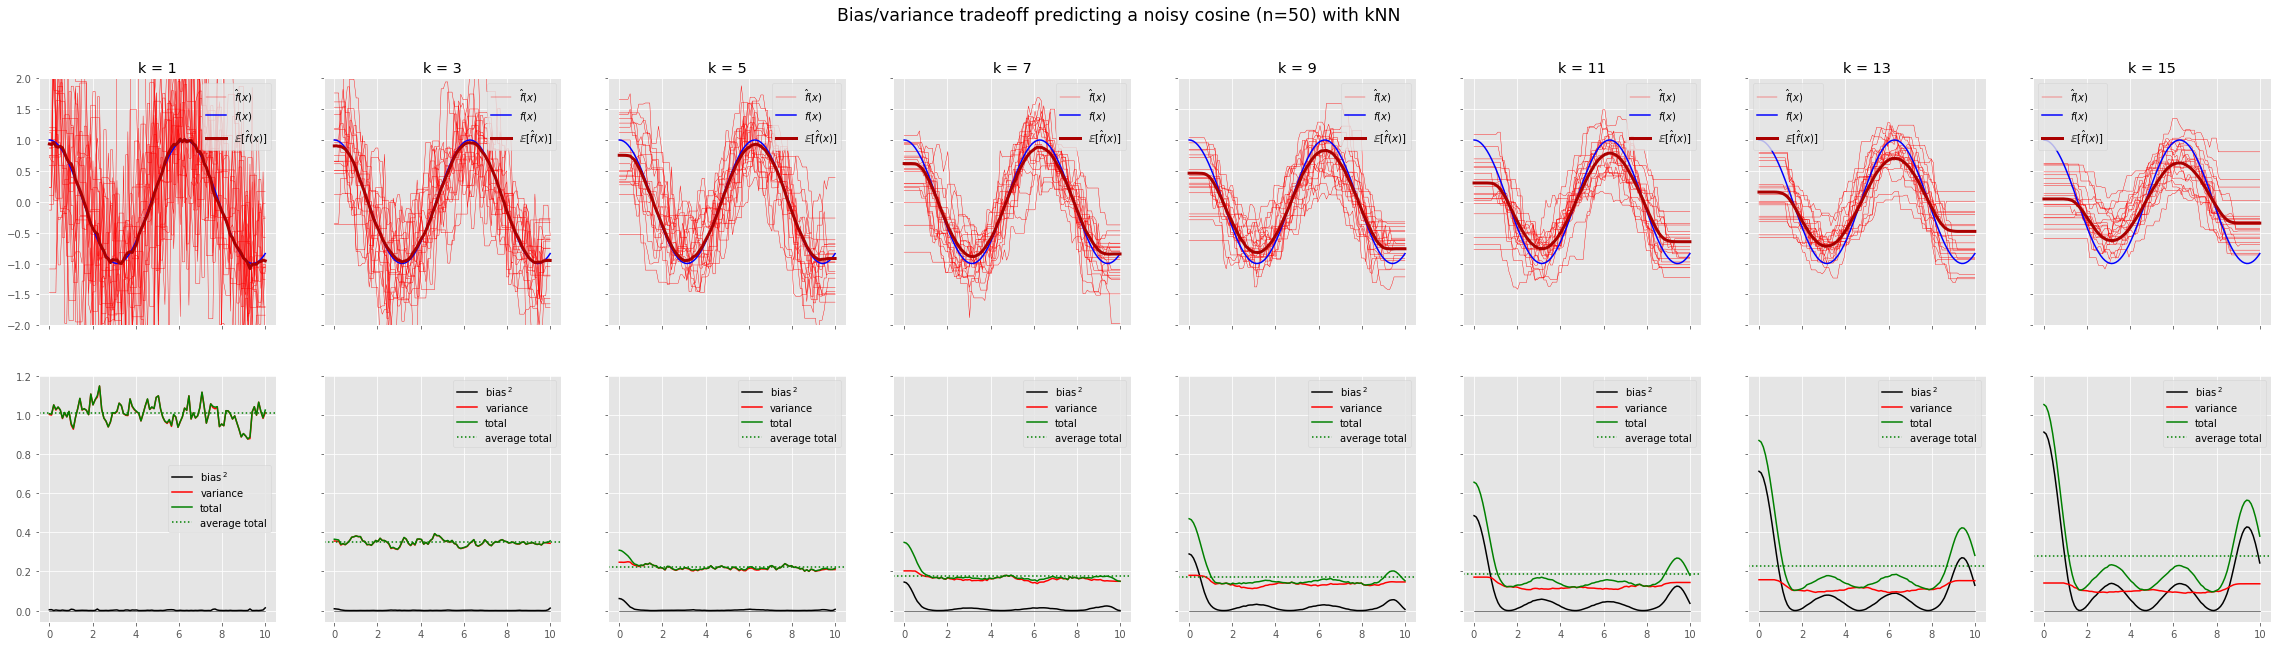

In [115]:
fig, axs = plt.subplots(2, 8, figsize=(40,10), sharey='row', sharex='all')

sample_size = 50
for i, k in enumerate((1,3,5,7,9,11,13,15)):
    model = KNeighborsRegressor(k)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"k = {k}")
fig.suptitle("Bias/variance tradeoff predicting a noisy cosine (n=50) with kNN", size='xx-large')
plt.savefig('bias-variance.png')

N.B. Although the bias when $k=1$ does not seen to be $0$, that's because we don't have enough samples. If we increase it enough it will converge.

Cool! Let's try the same thing with decision trees

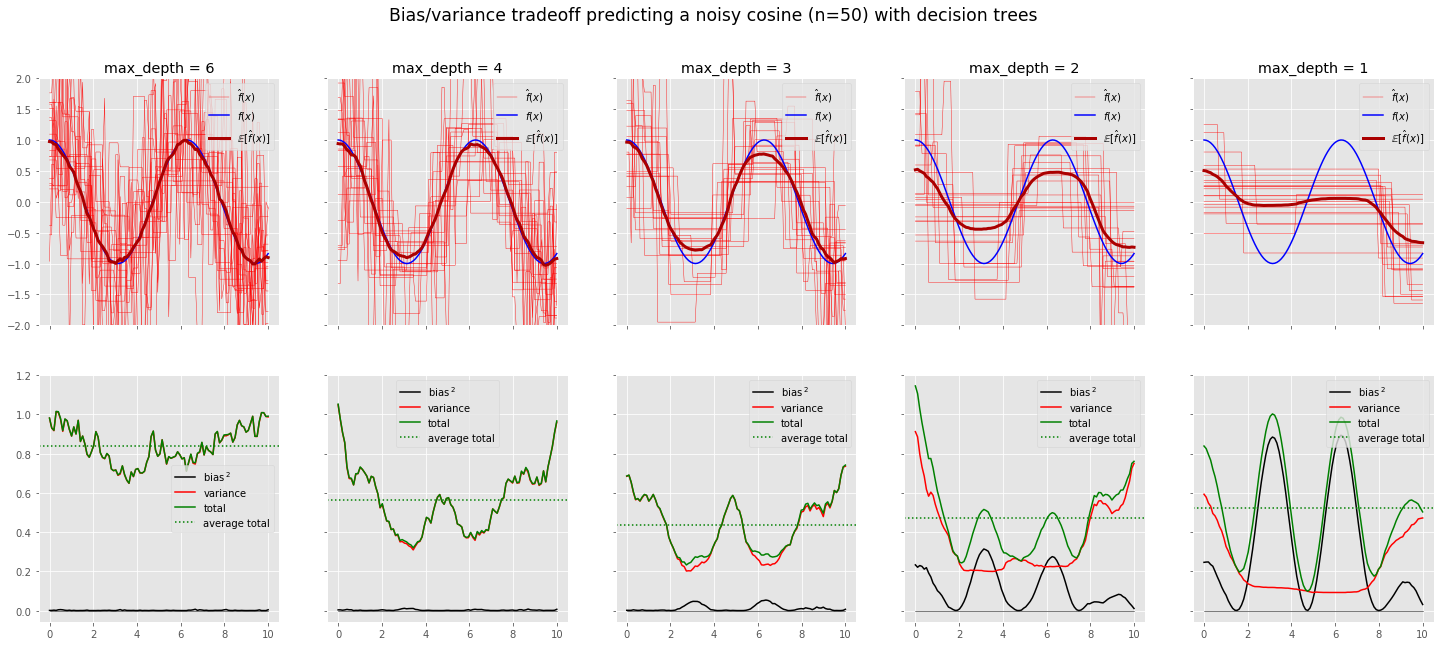

In [108]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
for i, depth in enumerate((6, 4, 3, 2, 1)):
    model = DecisionTreeRegressor(max_depth=depth)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"max_depth = {depth}")
fig.suptitle("Bias/variance tradeoff predicting a noisy cosine (n=50) with decision trees", size='xx-large')

Interesting. It looks as if it's hard to do better than a depth-1 tree. Let's try a different hyperparameter.

Text(0.5, 0.98, 'Bias/variance tradeoff predicting a noisy cosine (n=50) with decision trees')

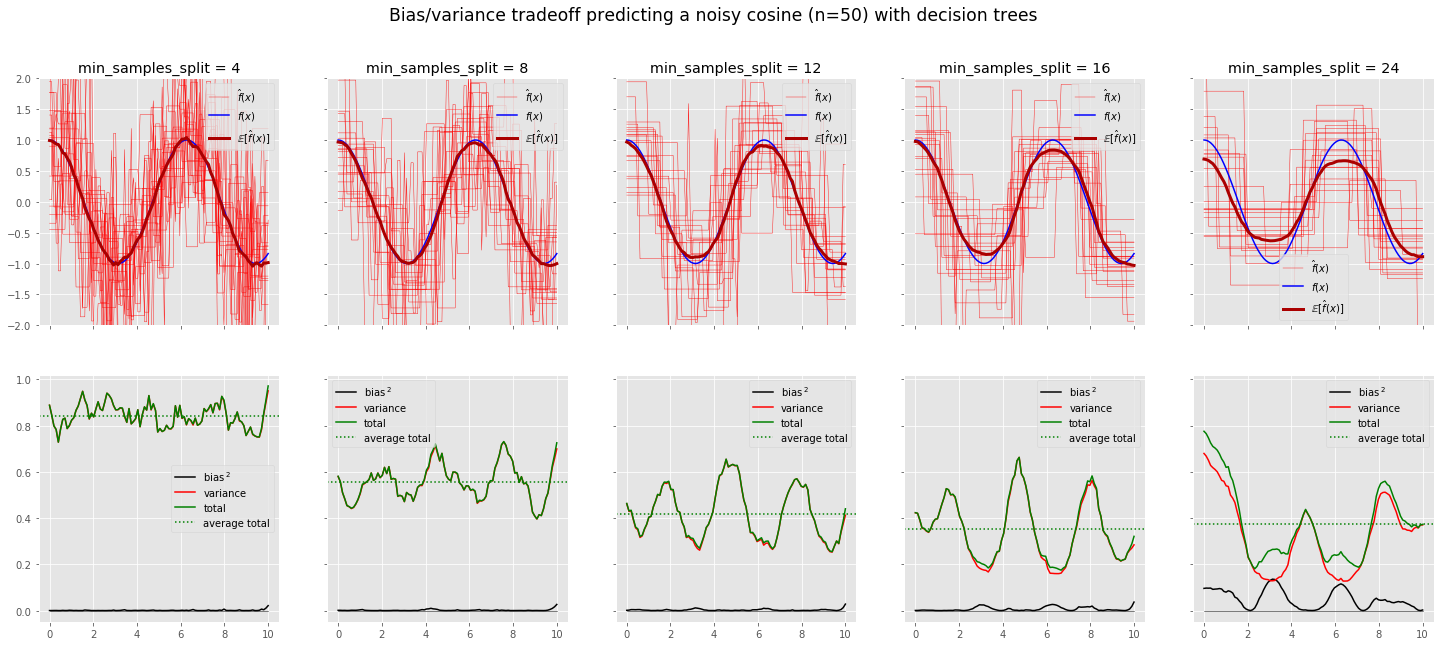

In [109]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

n_trials = 100
sample_size = 50
for i, min_samples_split in enumerate((4, 8, 12, 16, 24)):
    model = DecisionTreeRegressor(min_samples_split=min_samples_split)
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"min_samples_split = {min_samples_split}")
fig.suptitle("Bias/variance tradeoff predicting a noisy cosine (n=50) with decision trees", size='xx-large')

That one seems better.

Now let's try linear models.

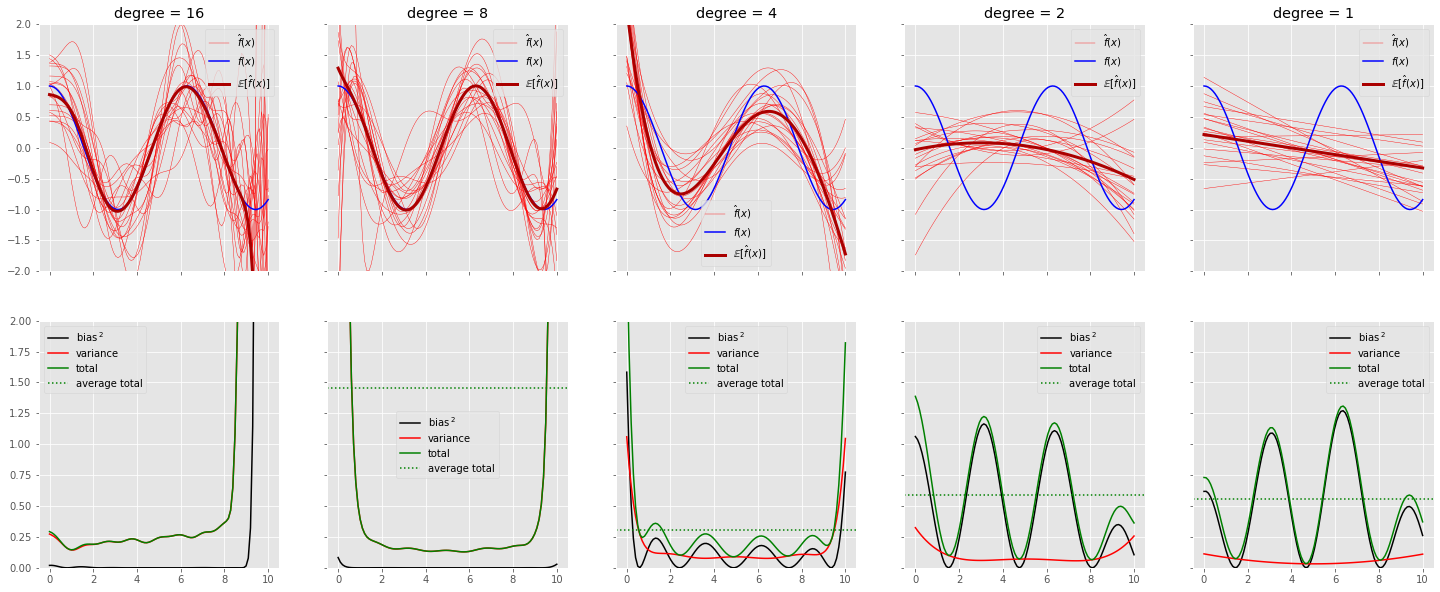

In [101]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)
n_trials = 100
sample_size = 50
for i, degree in enumerate((16, 8, 4, 2, 1)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(degree)),
                            ('lr', LinearRegression())])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"degree = {degree}")
fig.suptitle("Bias/variance tradeoff predicting a noisy cosine (n=50) with polynomial regression", size='xx-large')

One might have expected that the a polynomial of sufficiently high degree would be a great way to predict a cosine. And the total of bias and variance at degree = 8 is really low...except at either end. It's so bad there, it makes the overall average worse than lower orders.

Polynomial regression: not so great.

Let's try it again with Ridge regression, changing $\alpha$, using a degree-five polynomial.

Text(0.5, 0.98, 'Bias/variance tradeoff predicing a noisy cosine (n=50) with regularized 5th-order polynomail regression')

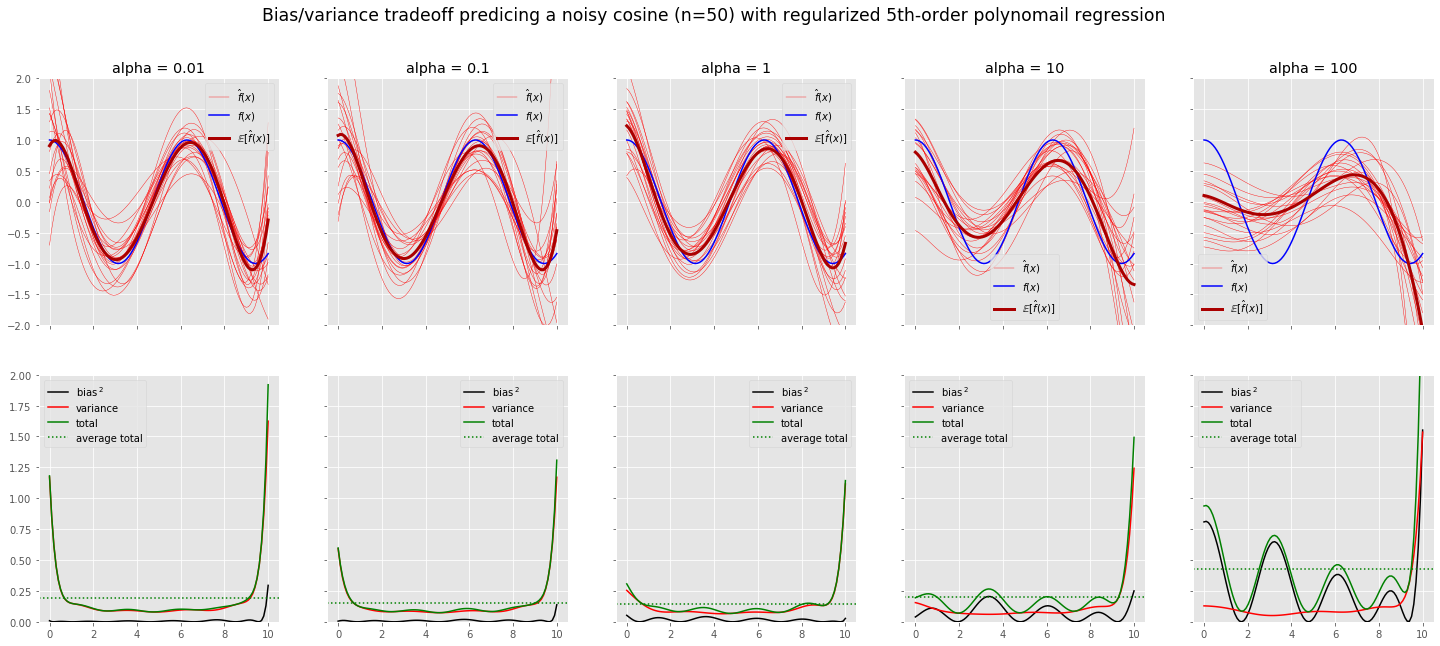

In [104]:
fig, axs = plt.subplots(2, 5, figsize=(25,10), sharey='row', sharex='all')

# limit y on the lower graph, because things blow up
axs[1, 0].set_ylim(0, 2)
n_trials = 100
sample_size = 50
for i, alpha in enumerate((0.01, 0.1, 1, 10, 100)):
    model = Pipeline(steps=[('poly', PolynomialFeatures(5)),
                            ('lr', Ridge(alpha=alpha))])
    plot_bias_variance(axs[0, i], axs[1, i], model, x_samples, label=f"alpha = {alpha}")
fig.suptitle("Bias/variance tradeoff predicting a noisy cosine (n=50) with regularized 5th-order polynomial regression", size='xx-large')

It's not a big difference.